In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#读取数据
test = pd.read_csv('C:/Users/ckhin/OneDrive/Documents/GitHub/MCM/arima/arima预测/train.csv',encoding='gbk')
#查看数据
print(test.head())                                  


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [24]:
%pip install xgboost
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

Note: you may need to restart the kernel to use updated packages.


In [25]:
#查看数据的基本信息
print(test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

##### 这里可以看见一共43个定性属性，36个定量属性

#### 训练集一共是1460个样本，测试集也是1460个样本

((19,), <Axes: >)

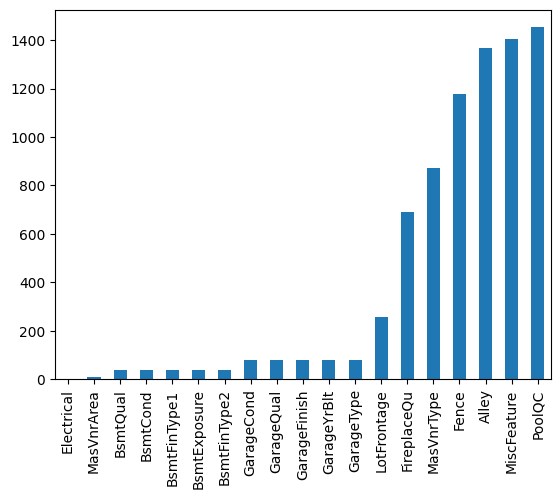

In [26]:
missing=test.isnull().sum()#统计每个特征的缺失值个数
missing=missing[missing>0]#只显示缺失值个数大于0的特征
missing.sort_values(inplace=True)   #排序

missing.shape,missing.plot.bar()#统计缺失值,总数绘制条形图

#### 这里可以看见有19个属性有缺失值，大多数时候 NA 意味着缺少属性描述的主题，例如缺少游泳池、栅栏、没有车库和地下室

C:\Users\ckhin\AppData\Local\Temp\ipykernel_26052\1004101407.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=st.johnsonsu)#拟合Johnson SU分布
C:\Users\ckhin\AppData\Local\Temp\ipykernel_26052\1004101407.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=st.no

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

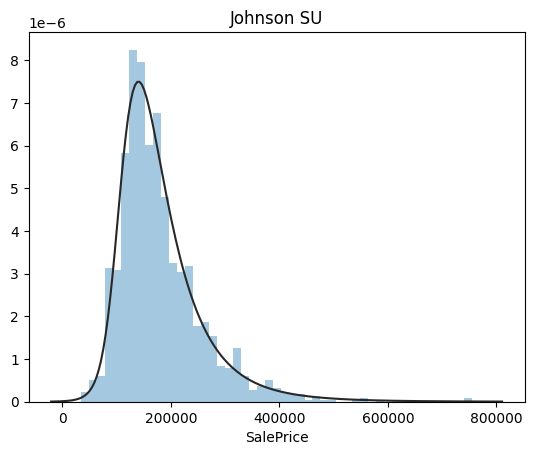

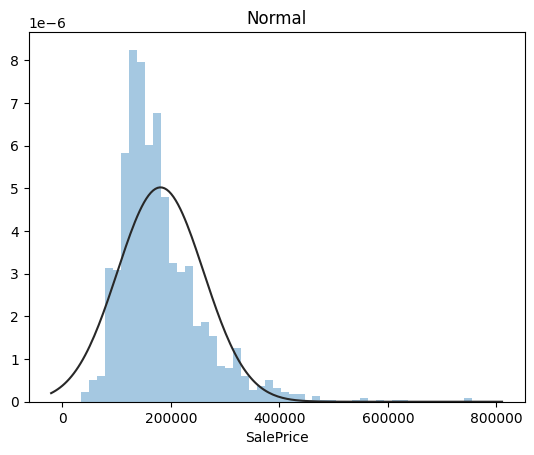

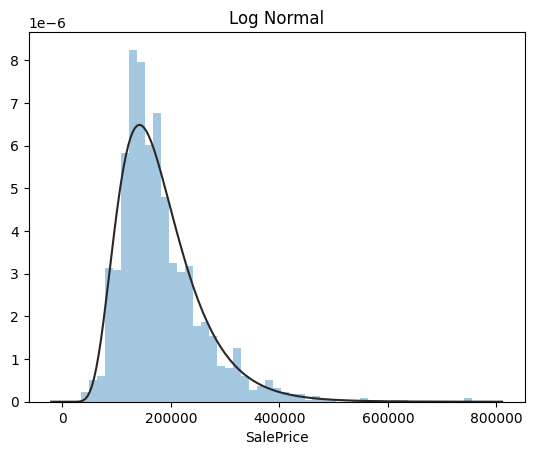

In [27]:
import scipy.stats as st
y = test['SalePrice']
plt.figure(1); plt.title('Johnson SU')#绘制直方图
sns.distplot(y, kde=False, fit=st.johnsonsu)#拟合Johnson SU分布
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)#拟合正态分布
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)#拟合对数正态分布

#### 很明显的发现这里的价格不符合正态分布，发现johnson分布的拟合效果是最好的

In [28]:
quantitative = [f for f in test.columns if test.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in test.columns if test.dtypes[f] == 'object']

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01#正态性检验
normal = pd.DataFrame(test[quantitative])#定量数据
normal = normal.apply(test_normality)#正态性检验
print(not normal.any())#如果所有特征都是正态分布，则返回True

False


c:\Python310\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Python310\lib\site-packages\seaborn\axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
c:\Python310\lib\site-packages\seaborn\axisgrid.py:854

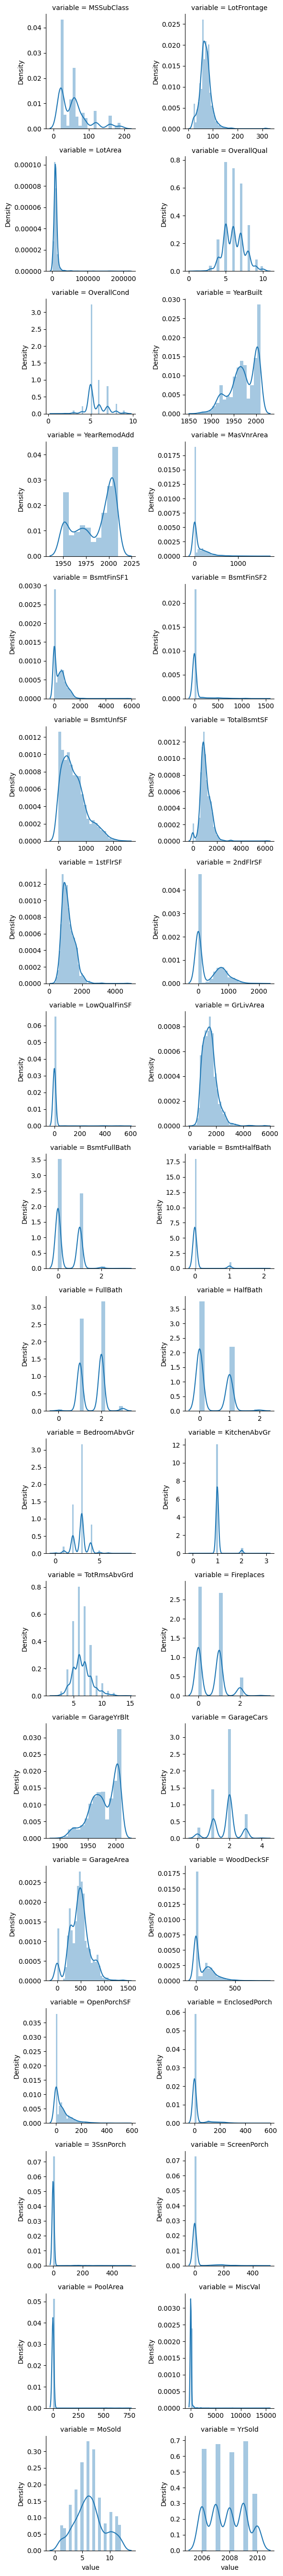

In [29]:
f = pd.melt(test, value_vars=quantitative)#将定量数据转换为长格式，便于绘制箱线图，每个特征的值都是一列
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)#绘制多个子图
g = g.map(sns.distplot, "value")#绘制箱线图

#### 这里观察到有的分布符合log分布

### 分类数据 <br>

#### 通过定性变量，我们可以实现两种方法。 第一个是检查 SalePrice 相对于变量值的分布并枚举它们。 其次为每个可能的类别创建虚拟变量

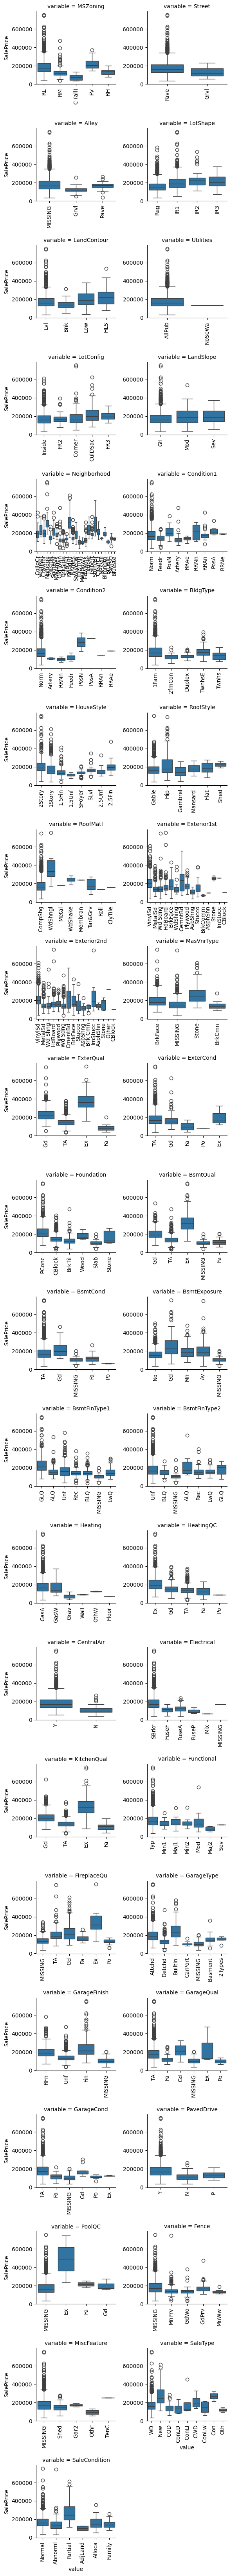

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

for c in qualitative:
    test[c] = test[c].astype('category')
    if test[c].isnull().any():
        test[c] = test[c].cat.add_categories(['MISSING'])
        test[c] = test[c].fillna('MISSING')

f = pd.melt(test, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(boxplot, "value", "SalePrice")

#### 可以看出不同条件对房价的影响不同，通过箱型图可以看出中位数等等的差异

#### 相关性分析

通过ANOVA分析得到disparity值（p——value的负对数）排序，这个值越大越可以说明和房价有关系

ANOVA分析需要各个样本数据满足正态分布

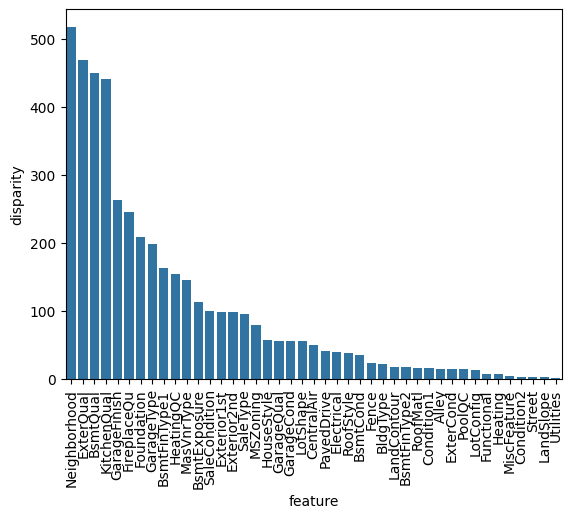

In [31]:
#方差分析（ANOVA）是一种统计学方法，用于比较两个或两个以上组的平均值之间的差异，以确定它们是否来自同一总体。
#这里是用来检验不太的特征是否对房价有影响

def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative#定性数据
    pvals = []#p值
    for c in qualitative:#对每个特征进行方差分析
        samples = []#样本
        for cls in frame[c].unique():#对每个特征的每个类别进行方差分析
            s = frame[frame[c] == cls]['SalePrice'].values#取出该类别的房价
            samples.append(s)#将该类别的房价加入样本
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')#按照p值排序

a = anova(test)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [32]:
#对定性数据进行独热编码

def encode(frame, feature):
    ordering = pd.DataFrame()#创建一个空的DataFrame
    ordering['val'] = frame[feature].unique()#取出特征的所有类别，去重
    ordering.index = ordering.val#将类别设置为索引
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']#计算每个类别的房价均值
    ordering = ordering.sort_values('spmean')#按照房价均值排序
    ordering['ordering'] = range(1, ordering.shape[0]+1)#给每个类别编号
    ordering = ordering['ordering'].to_dict()#将编号转换为字典
    
    for cat, o in ordering.items():#对每个类别进行编号
        frame.loc[frame[feature] == cat, feature+'_E'] = o#将编号加入原数据集
    
qual_encoded = []
for q in qualitative:  
    encode(test, q)#对每个定性数据进行独热编码
    qual_encoded.append(q+'_E')
print(qual_encoded)#独热编码后的特征,根据编码后的特征进行相关性分析

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


C:\Users\ckhin\AppData\Local\Temp\ipykernel_26052\2913837203.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']#计算每个类别的房价均值
C:\Users\ckhin\AppData\Local\Temp\ipykernel_26052\2913837203.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']#计算每个类别的房价均值
C:\Users\ckhin\AppData\Local\Temp\ipykernel_26052\2913837203.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

斯皮尔曼相关性分析不需要变量符合正态分布，用来分析定性属性相关分析

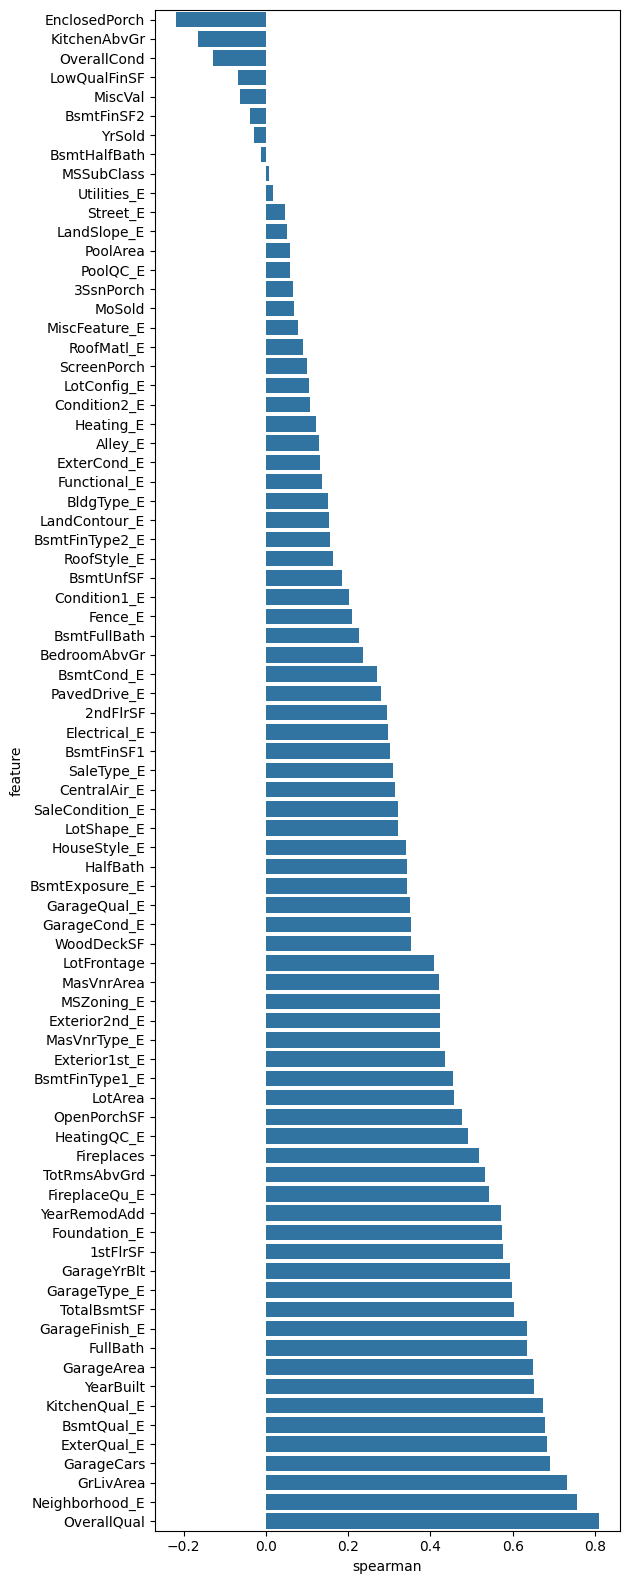

In [33]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
spearman(test, features)

c:\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

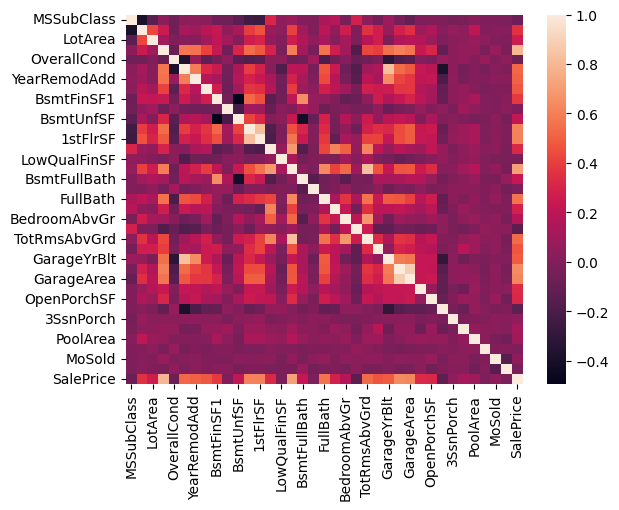

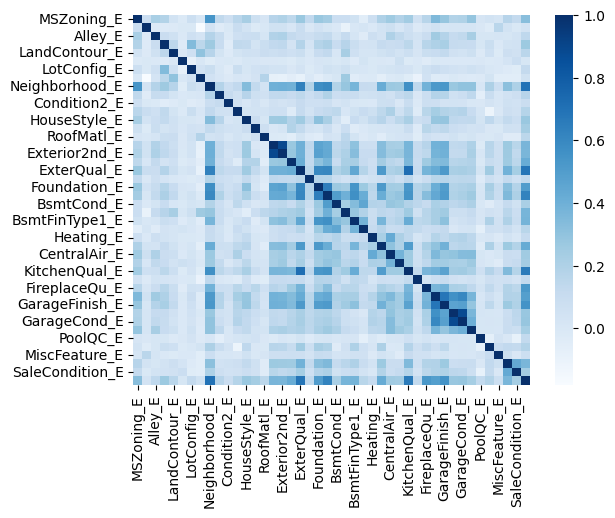

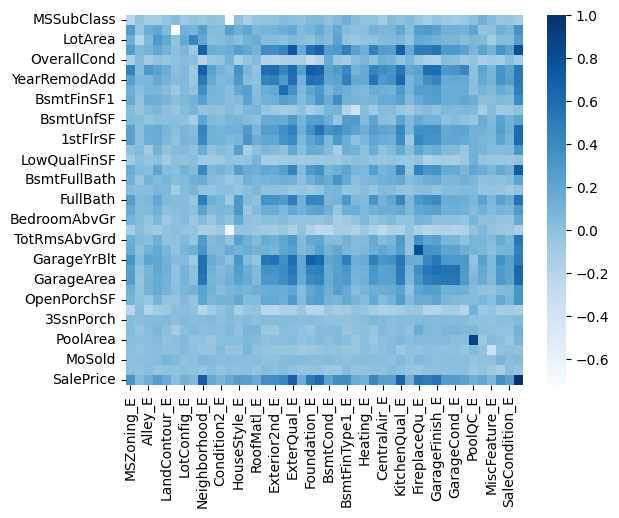

In [34]:
plt.figure(1)
corr = test[quantitative+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = test[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr,cmap="Blues")
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = test[q1].corr(test[q2])
sns.heatmap(corr,cmap="Blues")

neighborhoood与许多其他变量相关，这证实了同一地区的房屋具有相同特征的想法。 住宅类型与地面以上厨房平方英尺呈负相关。

#### Pairplots

Pairplots 是一种数据可视化方法，它在一个网格中展示了多个变量之间的双变量关系。对于房价数据集来说，每个独立变量（如房屋面积、建造年份、房间数量等）都会与房价形成一对，然后为每一对变量绘制散点图。这样，每个散点图展示了房价与一个特定独立变量之间的关系。

通过观察这些pairplots，分析师可以寻找一些可能的模式，例如：

正相关：独立变量值增加时，房价也增加。<br>
负相关：独立变量值增加时，房价减少。<br>
非线性关系：房价随着独立变量的变化而变化，但这种变化不是直线关系，可能是曲线或其他复杂形式。<br>
无关系：房价与独立变量之间没有明显的关系。<br>
异常值：一些不符合总体趋势的数据点，可能指示特殊情况或数据记录错误。<br>

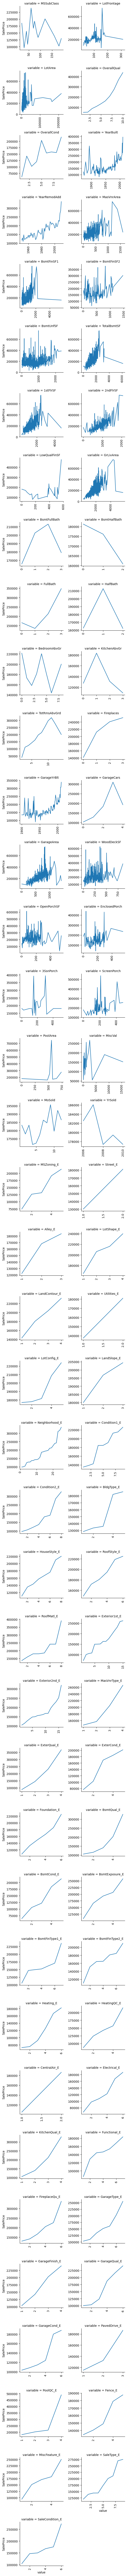

In [35]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(test, id_vars=['SalePrice'], value_vars=quantitative+qual_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(pairplot, "value", "SalePrice")


#### 价格分段比较

比较不同价格范围的房屋在各个量化特征上的平均值差异。<br>
标准价位房屋（房价低于200,000美元）和高价位房屋（房价等于或高于200,000美元）。<br>
然后计算每个量化特征在这两个价格范围内的平均值差异的百分比。

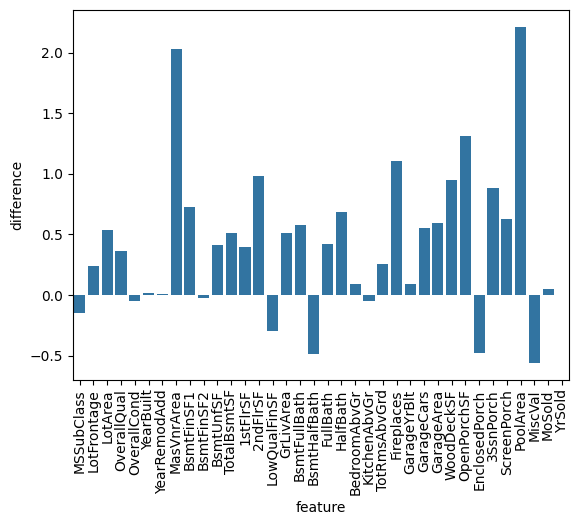

In [36]:
features = quantitative

standard = test[test['SalePrice'] < 200000]#房价小于20万的样本
pricey = test[test['SalePrice'] >= 200000]#房价大于20万的样本

diff = pd.DataFrame()#创建一个空的DataFrame
diff['feature'] = features#特征
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/(standard[f].fillna(0.).mean())
                      for f in features]#计算两个样本的均值差异,并归一化,归一化后的差异越大,说明该特征对房价的影响越大

sns.barplot(data=diff, x='feature', y='difference')#绘制条形图
x=plt.xticks(rotation=90)

#### 聚类

对于非线性关系的特征使用TSNE的降维效果更好<br>
这里先使用TSNE算法来对quantitative特征来进行降维处理<br>
然后使用Kmeans算法来进行聚类<br>

这里使用PCA算法来进行方差解释
这里发现PCA选择的前30个主成分总共捕获了原始数据集75%的方差。<br>
方差在这里可以被视为数据的信息量，所以这30个成分保留了大部分的信息。<br>


0.7505104785145966


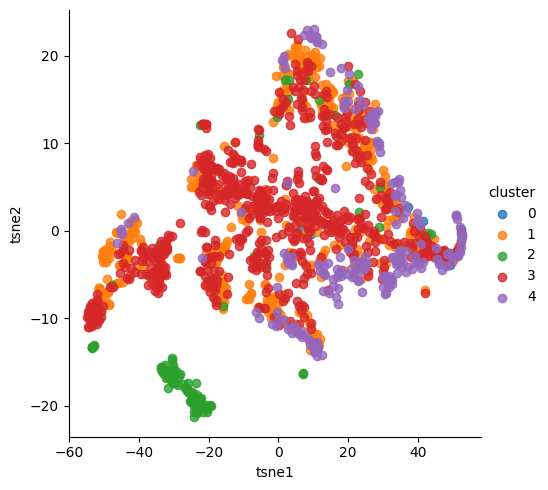

In [37]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)#降维,降到2维,TSNE算法,perplexity是困惑度,越大越好
X = test[features].fillna(0.).values#取出所有特征的值,并填充缺失值
tsne = model.fit_transform(X)#降维

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

#### 房价分布

这里使用了Johnson SU转换把非正态分布转化为正态分布  

C:\Users\ckhin\AppData\Local\Temp\ipykernel_26052\140294075.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yt)
C:\Users\ckhin\AppData\Local\Temp\ipykernel_26052\140294075.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yt2)


<Axes: ylabel='Density'>

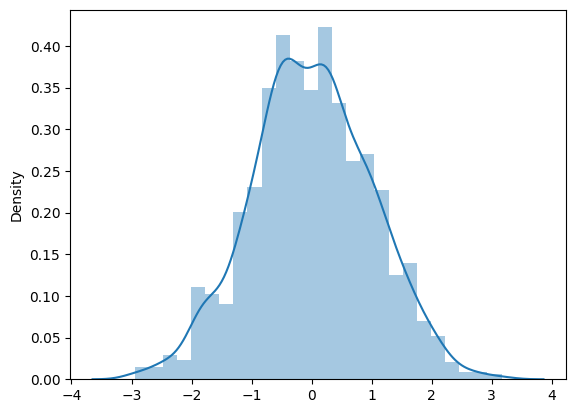

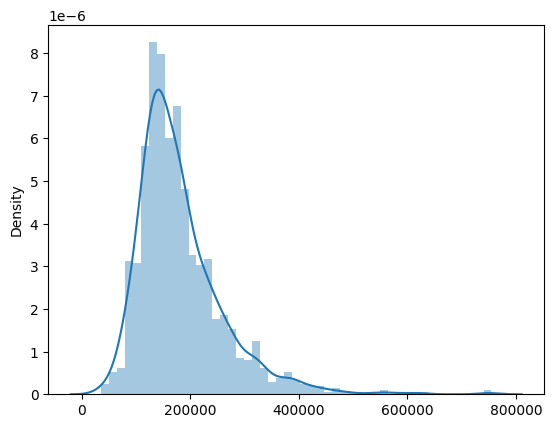

In [38]:
y = test['SalePrice'].values
def johnson(y):
    gamma, eta, epsilon, lbda = stats.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    return lbda*np.sinh((y-gamma)/eta) + epsilon

yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)
plt.figure(1)
sns.distplot(yt)
plt.figure(2)
sns.distplot(yt2)

#### 回归预测

In [39]:
test['HasBasement'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasGarage'] = test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFloor'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasMasVnr'] = test['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
test['HasWoodDeck'] = test['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasPorch'] = test['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasPool'] = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test['IsNew'] = test['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    test[feature] = np.log1p(test[feature].values)

def quadratic(feature):
    test[feature+'2'] = test[feature]**2
   
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
    '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

Y = test['SalePrice'].values

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = test[features].fillna(0.).values
Y = test['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

0.10960531332114518

In [40]:
#对pre数据集进行预处理
pre=pd.read_csv('pre.csv',encoding='gbk')
pre['SalePrice']=0.0
pre.info()


FileNotFoundError: [Errno 2] No such file or directory: 'pre.csv'

In [ ]:
quantitative = [f for f in pre.columns if pre.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in pre.columns if pre.dtypes[f] == 'object']

In [ ]:
for c in qualitative:
    pre[c] = pre[c].astype('category')
    if pre[c].isnull().any():
        pre[c] = pre[c].cat.add_categories(['MISSING'])
        pre[c] = pre[c].fillna('MISSING')


In [ ]:
def encode(frame, feature):
    ordering = pd.DataFrame()#创建一个空的DataFrame
    ordering['val'] = frame[feature].unique()#取出特征的所有类别，去重
    ordering.index = ordering.val#将类别设置为索引
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']#计算每个类别的房价均值
    ordering = ordering.sort_values('spmean')#按照房价均值排序
    ordering['ordering'] = range(1, ordering.shape[0]+1)#给每个类别编号
    ordering = ordering['ordering'].to_dict()#将编号转换为字典
    
    for cat, o in ordering.items():#对每个类别进行编号
        frame.loc[frame[feature] == cat, feature+'_E'] = o#将编号加入原数据集
    
qual_encoded = []
for q in qualitative:  
    encode(pre, q)#对每个定性数据进行独热编码
    qual_encoded.append(q+'_E')
print(qual_encoded)#独热编码后的特征,根据编码后的特征进行相关性分析

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [ ]:
# 创建二元特征
pre['HasBasement'] = pre['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
pre['HasGarage'] = pre['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
pre['Has2ndFloor'] = pre['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
pre['HasMasVnr'] = pre['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
pre['HasWoodDeck'] = pre['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
pre['HasPorch'] = pre['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
pre['HasPool'] = pre['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
pre['IsNew'] = pre['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

# 对特定特征进行对数变换
def log_transform(feature):
    pre[feature] = np.log1p(pre[feature])

# 对特定特征添加二次项
def quadratic(feature):
    pre[feature+'2'] = pre[feature]**2

# 应用对数变换
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

# 应用二次变换
quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

# 二次特征列表
qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
       '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

# 布尔特征列表
boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
           'HasPorch', 'HasPool', 'IsNew']

# 特征集合
features = quantitative + qual_encoded + boolean + qdr

# 模型预测

X_pre = pre[features].fillna(0.).values
Y_pred_log = lasso.predict(X_pre)  # 预测的是对数转换后的房价
Y_pred = np.exp(Y_pred_log)  # 转换回原始尺度

In [ ]:
#将预测结果写入文件
pre['SalePrice'] = Y_pred
pre[['Id', 'SalePrice']].to_csv('submission.csv', index=False)
